# Model Training

Description here

## 1. Import Libraries dan Load Datasets

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import glob
import math
import time
import os

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date


## import statistical library
from scipy.stats import spearmanr
import scipy.stats as stats


# import viz libraries
import plotly.express as px
import plotly.graph_objects as go
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline


# import model libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model



In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [3]:
# set file path
file_path = "../datasets/processed/daily-pm25-gsod-cleaned.csv"

# load dataset
df = pd.read_csv(file_path, parse_dates=["tanggal"], index_col=["tanggal"]).sort_index(ascending=True)

# display tiga baris pertama
df.head(3)

,lokasi,pm25,aqi,kategori,temperatur,curah_hujan,jarak_pandang,kecepatan_angin
tanggal,,,,,,,,
2016-01-01,Jakarta Selatan,22.3,72.5,Sedang,28.11,0.00,4.1,3.3
2016-01-01,Jakarta Pusat,31.4,91.6,Sedang,28.11,0.00,4.1,3.3
2016-01-02,Jakarta Pusat,31.0,90.7,Sedang,27.44,15.24,3.9,3.2


## 2. Preprocessing

In [4]:
# filter lokasi di jakarta pusat
# extract hanya kolom pm25
pm25_df = df[df["lokasi"]=="Jakarta Pusat"]
pm25_df = pm25_df.filter(["pm25"])

# display lima baris pertama
pm25_df.head()

,pm25
tanggal,
2016-01-01,31.40
2016-01-02,31.00
2016-01-03,27.40
2016-01-04,52.80
2016-01-05,60.75


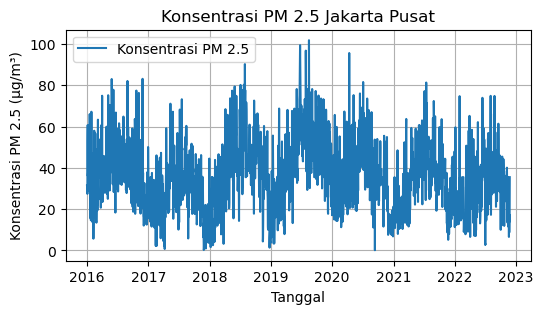

In [5]:
# display closing price from each stock

# lq45 - kompas
plt.figure(figsize=(6,3))
plt.title('Konsentrasi PM 2.5 Jakarta Pusat')
plt.plot(pm25_df["pm25"])

plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi PM 2.5 (μg/m\u00b3)')
plt.legend(['Konsentrasi PM 2.5'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

In [6]:
# extract values
conc = pm25_df.values

In [7]:
# normalize
scaler = MinMaxScaler(feature_range=(0,1))
conc = scaler.fit_transform(np.array(conc).reshape(-1,1))

# display
conc

array([[0.30761671],
       [0.3036855 ],
       [0.26830467],
       ...,
       [0.16855037],
       [0.13611794],
       [0.34791155]])

### Split Dataset

In [8]:
# take 80% untuk training dan 20% untuk validasi
train_size = int(len(conc)*0.8)
test_size = len(conc) - train_size
train_data, test_data = conc[0:train_size,:], conc[train_size:len(conc),:1]

print("jumlah train data: ", len(train_data))
print("jumlah test data: ", len(test_data))

jumlah train data:  2016
jumlah test data:  505


In [9]:
# build function untuk convert array menjadi dataset matrix
# reshape  X=t and Y=t+1
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
# set window 30 hari
look_back = 30

# call function
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_valid = create_dataset(test_data, look_back)

In [11]:
# reshape input menjadi 3D (num_samples, num_timesteps, num_features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [39]:
X_test

array([[[0.56658477],
        [0.45896806],
        [0.37886978],
        ...,
        [0.39066339],
        [0.43341523],
        [0.28599509]],

       [[0.45896806],
        [0.37886978],
        [0.23882064],
        ...,
        [0.43341523],
        [0.28599509],
        [0.37886978]],

       [[0.37886978],
        [0.23882064],
        [0.52628993],
        ...,
        [0.28599509],
        [0.37886978],
        [0.25110565]],

       ...,

       [[0.11597052],
        [0.34791155],
        [0.34791155],
        ...,
        [0.15577396],
        [0.06339066],
        [0.16609337]],

       [[0.34791155],
        [0.34791155],
        [0.34791155],
        ...,
        [0.06339066],
        [0.16609337],
        [0.08452088]],

       [[0.34791155],
        [0.34791155],
        [0.34791155],
        ...,
        [0.16609337],
        [0.08452088],
        [0.16855037]]])

## 3. Model Training

### 3.1 Build Model Architecture

<li>Define the LSTM</li>
<li>Input shape: 1 time step with 30 features</li>
<li>Dropout 20%</li>
<li>Use MSE loss function, optimizer Adam</li>
<li>Try 100 training epochs with a batch size of 32/64</li>
<li>Prevent model from overfitting with EarlyStopping</li>

In [12]:
model = Sequential()
model.add(LSTM(75, return_sequences=True, input_shape=(30,1), name="LSTM_PM25_1"))
model.add(Dropout(0.2, name="FirstDropout"))

model.add(LSTM(75, return_sequences=True, name="LSTM_PM25_2"))
model.add(Dropout(0.2, name="SecondDropout"))

model.add(LSTM(75,name="LSTM_PM25_3"))           

model.add(Dense(1))

# adam = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer="adam")

In [13]:
# display summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_PM25_1 (LSTM)          (None, 30, 75)            23100     
                                                                 
 FirstDropout (Dropout)      (None, 30, 75)            0         
                                                                 
 LSTM_PM25_2 (LSTM)          (None, 30, 75)            45300     
                                                                 
 SecondDropout (Dropout)     (None, 30, 75)            0         
                                                                 
 LSTM_PM25_3 (LSTM)          (None, 75)                45300     
                                                                 
 dense (Dense)               (None, 1)                 76        
                                                                 
Total params: 113,776
Trainable params: 113,776
Non-trai

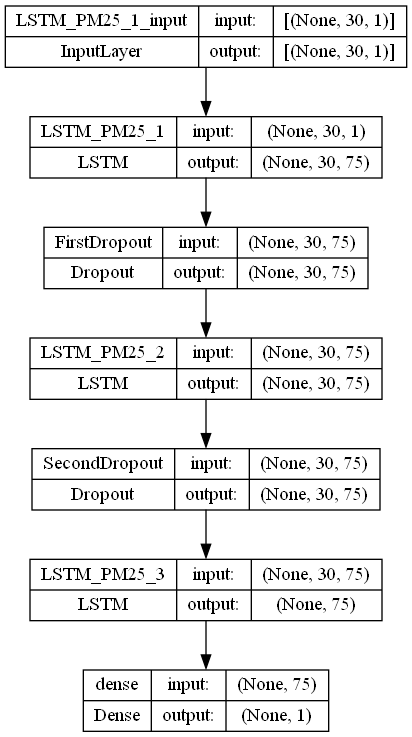

In [14]:
# Plot Model
plot_model(model, "../figures/lstm-architecture.png" , show_shapes=True, show_layer_names=True)

### 3.2 Train the Model and Make Predict on Train-Test Data

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_valid), validation_split=0.2, epochs=100, batch_size=32, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1)

Epoch 1/100
63/63 [==============================] - 10s 76ms/step - loss: 0.0239 - val_loss: 0.0163
Epoch 2/100
63/63 [==============================] - 4s 57ms/step - loss: 0.0173 - val_loss: 0.0159
Epoch 3/100
63/63 [==============================] - 3s 48ms/step - loss: 0.0178 - val_loss: 0.0154
Epoch 4/100
63/63 [==============================] - 3s 52ms/step - loss: 0.0175 - val_loss: 0.0180
Epoch 5/100
63/63 [==============================] - 3s 44ms/step - loss: 0.0173 - val_loss: 0.0150
Epoch 6/100
63/63 [==============================] - 3s 44ms/step - loss: 0.0166 - val_loss: 0.0157
Epoch 7/100
63/63 [==============================] - 3s 44ms/step - loss: 0.0173 - val_loss: 0.0154
Epoch 8/100
63/63 [==============================] - 3s 44ms/step - loss: 0.0164 - val_loss: 0.0146
Epoch 9/100
63/63 [==============================] - 3s 54ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 10/100
63/63 [==============================] - 3s 55ms/step - loss: 0.0155 - val_loss: 0.017

visualize the loss

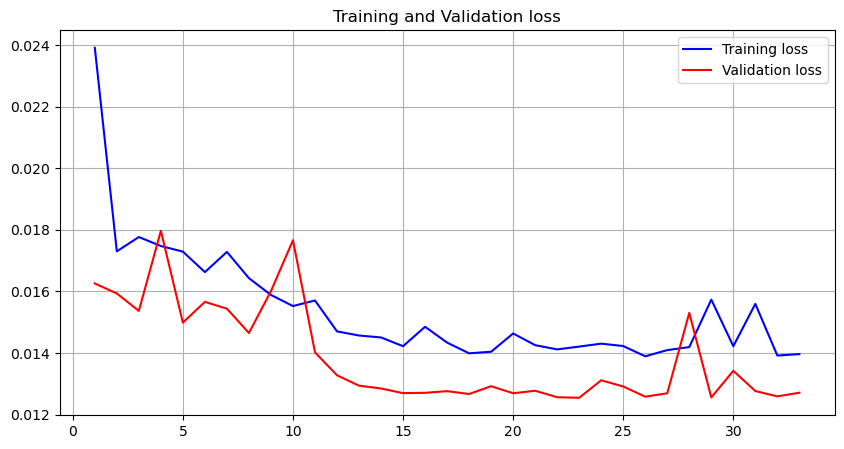

In [34]:
# viz loss
plt.gcf().set_size_inches(10, 5, forward=True)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

# train - validation loss 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.grid()
plt.savefig('../figures/lstm-learning-curves.jpg')
plt.show()

Looks good enough, bisa disimpan lebih dulu dan diload untuk prediksi.

In [17]:
# save model
model.save("../models/first-lstm-model.h5")

##### Predict Model on Data Test

In [18]:
# load model
use_model = load_model("../models/first-lstm-model.h5")

In [19]:
### prediksi
train_predict = use_model.predict(X_train)
test_predict = use_model.predict(X_test)

15/15 [==============================] - 0s 12ms/step


In [20]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
# calculate rmse train
rmse_train = math.sqrt(mean_squared_error(y_train, train_predict))
# calculate test train
rmse_test = math.sqrt(mean_squared_error(y_valid, test_predict))


print("rmse on train set: ", rmse_train)
print("rmse on test set: ", rmse_test)

rmse on train set:  38.81337099137166
rmse on test set:  33.38951535946816


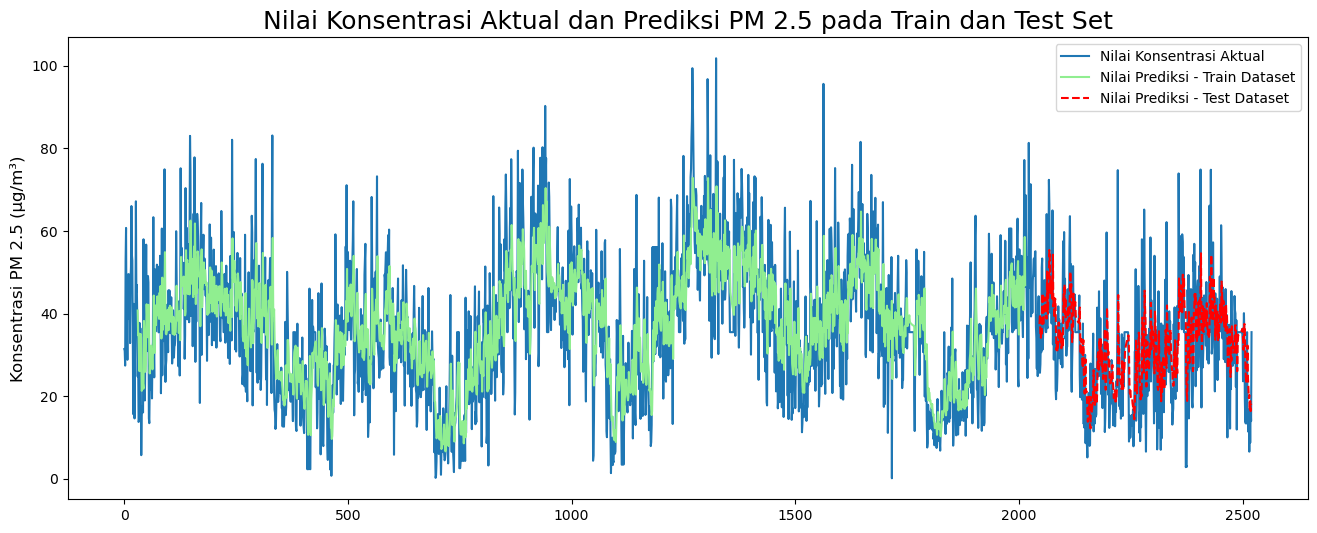

In [35]:
# plotting
plt.gcf().set_size_inches(16, 6, forward=True)
currentFig = plt.gcf()

trainPredictPlot = np.empty_like(conc)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(conc)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+look_back*2 + 1: len(conc)-1, :] = test_predict

plt.plot(scaler.inverse_transform(conc), label="Nilai Konsentrasi Aktual")
plt.plot(trainPredictPlot, label="Nilai Prediksi - Train Dataset", color="lightgreen")
plt.plot(testPredictPlot, label="Nilai Prediksi - Test Dataset", color="r", linestyle="dashed")


# styling
currentFig.set_facecolor('white')
plt.legend()
# plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Konsentrasi PM 2.5 (μg/m\u00b3)', fontsize=12)
plt.title('Nilai Konsentrasi Aktual dan Prediksi PM 2.5 pada Train dan Test Set', fontsize=18)

plt.savefig('../figures/lstm-prediction-results.jpg')
plt.show()

## 4. Make Forecasting

In [23]:
# load latest dataset
latest_data = "../datasets/processed/daily-pm25-gsod-cleaned.csv"

# load dataset
latest_df = pd.read_csv(file_path, parse_dates=["tanggal"], index_col=["tanggal"]).sort_index(ascending=True)

# filter lokasi di jakarta pusat
# extract hanya kolom pm25, aqi, kategori
jakpus = latest_df[latest_df["lokasi"]=="Jakarta Pusat"]
jakpus = jakpus.filter(["pm25", "aqi", "kategori"])

# display lima baris pertama
jakpus.tail(10)


,pm25,aqi,kategori
tanggal,,,
2022-11-16,13.25,53.4,Sedang
2022-11-17,15.15,57.4,Sedang
2022-11-18,11.35,47.3,Baik
2022-11-19,15.95,59.1,Sedang
2022-11-20,6.55,27.3,Baik
2022-11-21,17.00,61.3,Sedang
2022-11-22,8.70,36.2,Baik
2022-11-23,17.25,61.8,Sedang
2022-11-24,13.95,54.9,Sedang


In [24]:
# preprocessing
df = jakpus.reset_index()["pm25"]
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

df


array([[0.30761671],
       [0.3036855 ],
       [0.26830467],
       ...,
       [0.16855037],
       [0.13611794],
       [0.34791155]])

In [25]:
train_size = int(len(df)*0.6)
test_size = len(df) - train_size
train_data, test_data = df[0:train_size,:], df[train_size:len(df),:1]

In [26]:
# load model
use_model = load_model("../models/first-lstm-model.h5")

In [27]:
# set input
x_input_test = test_data[-30:].reshape(1,-1)
temp_input = list(x_input_test)
temp_input = temp_input[0].tolist()

In [28]:
# predict future concentration
future_list = []
n_steps = 30
i = 0

# for 1 week (7 days)
while(i<7):
        if (len(temp_input)>30):
                x_input_test=np.array(temp_input[1:])
                print("{} day input {}".format(i,x_input_test))
                x_input_test = x_input_test.reshape(1,-1)
                x_input_test = x_input_test.reshape((1,n_steps,1))
                y_hat = use_model.predict(x_input_test, verbose=0)
                print("{} day output {}".format(i, y_hat))
                temp_input.extend(y_hat[0].tolist())
                temp_input = temp_input[1:]
                future_list.extend(y_hat.tolist())
                i = i + 1
        else:
                x_input_test = x_input_test.reshape((1,n_steps,1))
                y_hat = use_model.predict(x_input_test, verbose=0)
                print(y_hat[0])
                temp_input.extend(y_hat[0].tolist())
                print(len(temp_input))
                future_list.extend(y_hat.tolist())
                i = i + 1


[0.2506433]
31
1 day input [0.34791155 0.34791155 0.34791155 0.34791155 0.34791155 0.34791155
 0.34791155 0.35528256 0.32874693 0.23095823 0.33660934 0.39312039
 0.33808354 0.19213759 0.13611794 0.13071253 0.19459459 0.26093366
 0.34791155 0.12923833 0.14791155 0.11056511 0.15577396 0.06339066
 0.16609337 0.08452088 0.16855037 0.13611794 0.34791155 0.25064331]
1 day output [[0.24044229]]
2 day input [0.34791155 0.34791155 0.34791155 0.34791155 0.34791155 0.34791155
 0.35528256 0.32874693 0.23095823 0.33660934 0.39312039 0.33808354
 0.19213759 0.13611794 0.13071253 0.19459459 0.26093366 0.34791155
 0.12923833 0.14791155 0.11056511 0.15577396 0.06339066 0.16609337
 0.08452088 0.16855037 0.13611794 0.34791155 0.25064331 0.24044229]
2 day output [[0.23187058]]
3 day input [0.34791155 0.34791155 0.34791155 0.34791155 0.34791155 0.35528256
 0.32874693 0.23095823 0.33660934 0.39312039 0.33808354 0.19213759
 0.13611794 0.13071253 0.19459459 0.26093366 0.34791155 0.12923833
 0.14791155 0.110565

In [29]:
# build future dataframe
today_date = date.today()
days = pd.date_range(start=today_date, periods=7)

In [30]:
# build historical dataframe
yesterday_data = jakpus.reset_index()
yesterday_data = yesterday_data[["tanggal", "pm25"]]
yesterday_data = yesterday_data.rename(columns={"pm25":"latest_pm25"})
yesterday_data = yesterday_data[-23:]
yesterday_data = yesterday_data.set_index(pd.DatetimeIndex(yesterday_data["tanggal"]))


# display
yesterday_data.tail()

,tanggal,latest_pm25
tanggal,,
2022-11-21,2022-11-21,17.00
2022-11-22,2022-11-22,8.70
2022-11-23,2022-11-23,17.25
2022-11-24,2022-11-24,13.95
2022-11-25,2022-11-25,35.50


In [31]:
yesterday_data.iloc[-1].values

array([Timestamp('2022-11-25 00:00:00'), 35.5], dtype=object)

In [32]:
future_list = scaler.inverse_transform(future_list)
future_df = pd.DataFrame(future_list)
future_df.insert(0, "tanggal", days)
future_df = future_df.rename(columns={0:"prediksi_pm25"})
future_df["prediksi_pm25"] = future_df["prediksi_pm25"].round(2)
future_df.loc[0] = yesterday_data.iloc[-1].values
future_df = future_df.set_index(pd.DatetimeIndex(future_df["tanggal"]))

# display
future_df

,tanggal,prediksi_pm25
tanggal,,
2022-11-25,2022-11-25,35.50
2022-11-27,2022-11-27,24.57
2022-11-28,2022-11-28,23.69
2022-11-29,2022-11-29,23.25
2022-11-30,2022-11-30,23.15
2022-12-01,2022-12-01,23.26
2022-12-02,2022-12-02,23.49


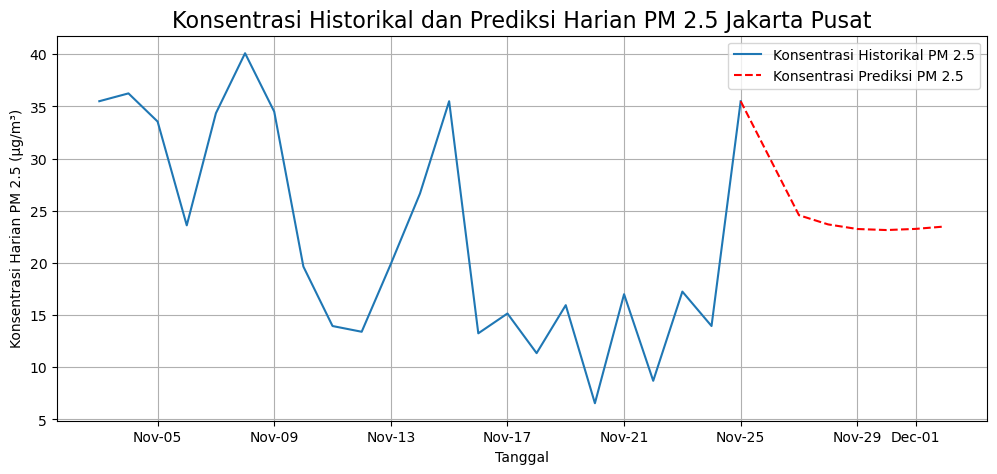

In [37]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches(12, 5, forward=True)

# plotting real values
plt.plot(yesterday_data["latest_pm25"], label="Konsentrasi Historikal PM 2.5")

# plotting forecasted values
plt.plot(future_df["prediksi_pm25"], label="Konsentrasi Prediksi PM 2.5", color="red", ls="--")

# styling
currentFig.set_facecolor('white')
plt.legend()
plt.xlabel('Tanggal', fontsize=10)
plt.ylabel('Konsentrasi Harian PM 2.5 (μg/m\u00b3)', fontsize=10)
plt.title('Konsentrasi Historikal dan Prediksi Harian PM 2.5 Jakarta Pusat', fontsize=16)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
plt.grid()
plt.savefig('../figures/lstm-forecasting.jpg')
plt.show()